<a href="https://colab.research.google.com/github/MarcoParola/medical_images_classification/blob/main/Scratch_CNN_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
pip install ipynb

In [37]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [38]:
import os
import numpy as np
import matplotlib.pyplot as plt
import collections 
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [39]:
projectPath = 'drive/MyDrive/Colab Notebooks/cidl/'
dataPath = 'numpy data/'

In [40]:
%cd $projectPath
%run utils.ipynb
%cd '../../../..'

/content/drive/MyDrive/Colab Notebooks/cidl
/content


In [41]:
# load data
imagesTrainPub, labelsTrainPub, imagesTestPub, labelsTestPub, imagesTestPriv = load_data(projectPath + dataPath)

# normalize data 
imagesTrainPub = scaleData(imagesTrainPub)
imagesTestPub = scaleData(imagesTestPub)

In [42]:
# create (if not exists) the folder to store the models
dir_name = 'models'
if not os.path.exists(projectPath + dir_name):
  os.makedirs(projectPath + dir_name)

# **Task 2**

## 2.1 Binary classification: Mass and Calcification
Classes:
*   Mass 1218
*   Calcification 1458

In [43]:
# 0 -> mass
# 1 -> calcification

# prepare trainig-set
trainingSet = []
trainingLabels = []

for i in range(len(labelsTrainPub)):
  if labelsTrainPub[i] == 1 or labelsTrainPub[i] == 2:
    trainingSet.append(imagesTrainPub[i])
    trainingLabels.append(0)
  if labelsTrainPub[i] == 3 or labelsTrainPub[i] == 4:
    trainingSet.append(imagesTrainPub[i])
    trainingLabels.append(1)

trainingSet = np.array(trainingSet)
trainingSet = trainingSet.reshape(2676, 150, 150, 1)

training = []
for i in range(len(trainingSet)):
  training.append((trainingSet[i], trainingLabels[i]))

training = np.array(training)
np.random.shuffle(training)


trainingSet = []
trainingLabels = []

for i in range(len(training)):
  trainingSet.append(training[i][0])
  trainingLabels.append(training[i][1])

trainingSet = np.array(trainingSet)
trainingLabels = np.array(trainingLabels)

# prepare test-set
testSet = []
testLabels = []

for i in range(len(labelsTestPub)):
  if labelsTestPub[i] == 1 or labelsTestPub[i] == 2:
    testSet.append(imagesTestPub[i])
    testLabels.append(0)
  if labelsTestPub[i] == 3 or labelsTestPub[i] == 4:
    testSet.append(imagesTestPub[i])
    testLabels.append(1)

testSet = np.array(testSet)
testSet = testSet.reshape(336, 150, 150, 1)

# the output must have a categorigal values
testLabelsCategorical = to_categorical(np.array(testLabels))
trainingLabelsCategorical = to_categorical(np.array(trainingLabels))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


# **TEST 1**

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 18, 18, 128)      

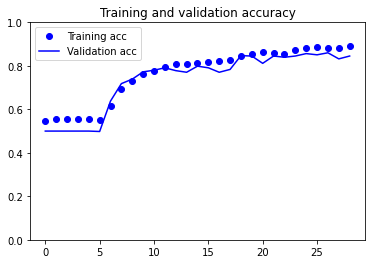

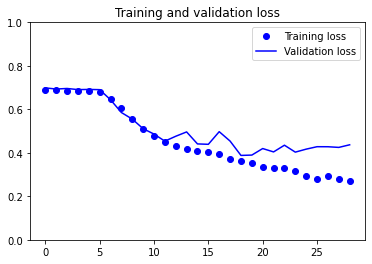

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


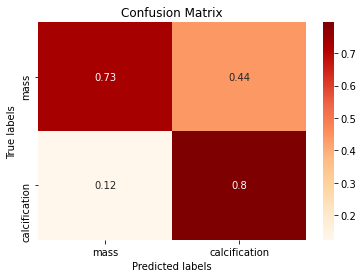

In [44]:
from tensorflow.keras import layers
from tensorflow.keras import models


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# bad result
#earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1)
earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = model.fit(trainingSet, trainingLabelsCategorical, epochs=100, callbacks=[earlyStopCallback], batch_size=32, validation_split=0.2)

test_loss, test_acc = model.evaluate(testSet, testLabelsCategorical)
print(test_loss, test_acc)
plot_accurancy_loss(history)
plot_confusionMatrix(model, testSet, testLabels)

# **TEST 2**

Epoch 1/100
67/67 [==============================] - 8s 94ms/step - loss: 0.6882 - accuracy: 0.5462 - val_loss: 0.6878 - val_accuracy: 0.5019
Epoch 2/100
67/67 [==============================] - 5s 82ms/step - loss: 0.6885 - accuracy: 0.5409 - val_loss: 0.7134 - val_accuracy: 0.5000
Epoch 3/100
67/67 [==============================] - 6s 83ms/step - loss: 0.6677 - accuracy: 0.6270 - val_loss: 0.6269 - val_accuracy: 0.6847
Epoch 4/100
67/67 [==============================] - 6s 83ms/step - loss: 0.6131 - accuracy: 0.7001 - val_loss: 0.5445 - val_accuracy: 0.7687
Epoch 5/100
67/67 [==============================] - 6s 83ms/step - loss: 0.5489 - accuracy: 0.7383 - val_loss: 0.4926 - val_accuracy: 0.7705
Epoch 6/100
67/67 [==============================] - 5s 82ms/step - loss: 0.5176 - accuracy: 0.7593 - val_loss: 0.4659 - val_accuracy: 0.7873
Epoch 7/100
67/67 [==============================] - 5s 81ms/step - loss: 0.4793 - accuracy: 0.7863 - val_loss: 0.4496 - val_accuracy: 0.8116
Epoch 

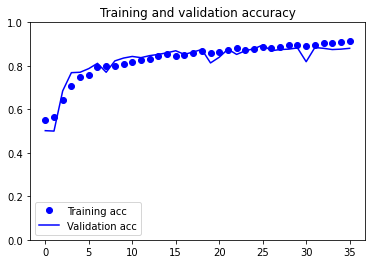

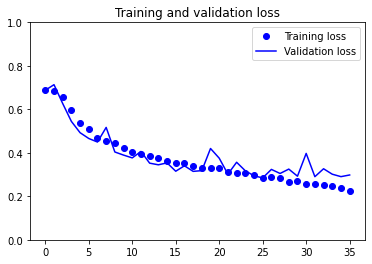

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


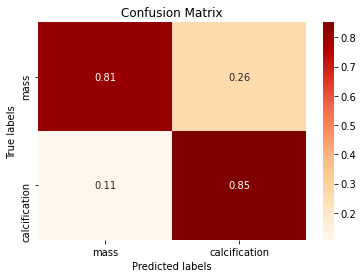

In [45]:
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow as tf
from keras import optimizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1), padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = model.fit(trainingSet, trainingLabelsCategorical, epochs=100, callbacks=[earlyStopCallback], batch_size=32, validation_split=0.2)

test_loss, test_acc = model.evaluate(testSet, testLabelsCategorical)
print(test_loss, test_acc)
plot_accurancy_loss(history)
plot_confusionMatrix(model, testSet, testLabels)

#**Test 3**
##**Improve the prevoius model**

In order to build a more generalized model, we inserted a drop-out layer between each convolutional layer and max-pooling layer.

Its rate is equal to 0.25, means that 1 neuron every 4 will not be randomly updated.

Epoch 1/100
67/67 [==============================] - 8s 99ms/step - loss: 0.6929 - accuracy: 0.5511 - val_loss: 0.6889 - val_accuracy: 0.6642
Epoch 2/100
67/67 [==============================] - 6s 97ms/step - loss: 0.6710 - accuracy: 0.6020 - val_loss: 0.6730 - val_accuracy: 0.5970
Epoch 3/100
67/67 [==============================] - 7s 97ms/step - loss: 0.6234 - accuracy: 0.6750 - val_loss: 0.6501 - val_accuracy: 0.6772
Epoch 4/100
67/67 [==============================] - 6s 97ms/step - loss: 0.5947 - accuracy: 0.6866 - val_loss: 0.6610 - val_accuracy: 0.5354
Epoch 5/100
67/67 [==============================] - 7s 97ms/step - loss: 0.5698 - accuracy: 0.7313 - val_loss: 0.6089 - val_accuracy: 0.7668
Epoch 6/100
67/67 [==============================] - 7s 97ms/step - loss: 0.5396 - accuracy: 0.7487 - val_loss: 0.6066 - val_accuracy: 0.7425
Epoch 7/100
67/67 [==============================] - 6s 97ms/step - loss: 0.5176 - accuracy: 0.7644 - val_loss: 0.5771 - val_accuracy: 0.7668
Epoch 

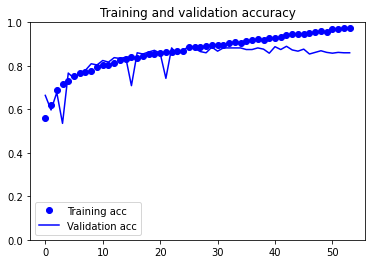

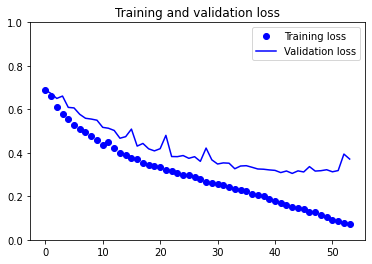

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


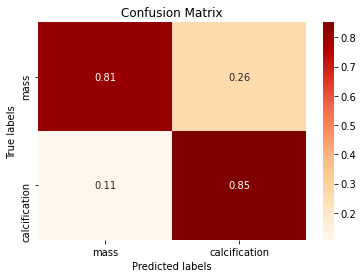

In [46]:
tf.random.set_seed(18)



from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow as tf
from keras import optimizers

modelDropout = models.Sequential()
modelDropout.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1), padding='same'))
modelDropout.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
modelDropout.add(layers.Dropout(rate=.25))
modelDropout.add(layers.MaxPooling2D((2, 2)))
modelDropout.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
modelDropout.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
modelDropout.add(layers.Dropout(rate=.25))
modelDropout.add(layers.MaxPooling2D((2, 2)))
modelDropout.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
modelDropout.add(layers.Dropout(rate=.25))
modelDropout.add(layers.MaxPooling2D((2, 2)))
modelDropout.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
modelDropout.add(layers.Dropout(rate=.25))
modelDropout.add(layers.MaxPooling2D((2, 2)))

modelDropout.add(layers.Flatten())
modelDropout.add(layers.Dense(256, activation='relu'))
modelDropout.add(layers.Dense(2, activation='sigmoid'))

modelDropout.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = modelDropout.fit(trainingSet, trainingLabelsCategorical, epochs=100, callbacks=[earlyStopCallback], batch_size=32, validation_split=0.2)

test_loss, test_acc = modelDropout.evaluate(testSet, testLabelsCategorical)
print(test_loss, test_acc)
plot_accurancy_loss(history)
plot_confusionMatrix(modelDropout, testSet, testLabels)

The prevoius conv-net's accurancy has not been improved, so we change the drop-out rate to 0.2, in order to have 4 neurons updated every five.